In [52]:
## STANDARD IMPORTS
import os
import time
import h5py
import numpy as np
import numpy.ma as ma
import pandas as pd
import json

# analysis
import scipy.stats
from scipy.optimize import curve_fit

# data handling
!pip3 install ../../../h5flow
import h5flow
from h5flow.data import dereference

## 3D PLOTTING
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm, colors
import matplotlib.patches as mpatches
from matplotlib.colors import BoundaryNorm

Processing /Users/james/DUNE/h5flow
  Preparing metadata (setup.py) ... done
  Created wheel for h5flow: filename=h5flow-0.2.4-py3-none-any.whl size=31486 sha256=467824e02d9ed3f3f4289c1ed25a2d38d28b3c6888378b596c70910ae315f715
  Stored in directory: /private/var/folders/rc/blk_p25x629bs2hm6s03qd7r0000gp/T/pip-ephem-wheel-cache-n9fbd1k0/wheels/24/88/52/69f8c19ba5cdb192c9c8611f03e4d3b4e2b4c27d2131bc4e20
Successfully built h5flow
  Attempting uninstall: h5flow
    Found existing installation: h5flow 0.2.4
    Uninstalling h5flow-0.2.4:
      Successfully uninstalled h5flow-0.2.4


In [53]:
dirname = 'mc_processed_MiniRun5_1E19_RHC.flow.0000000.FLOW_nfiles_6_TrapType_evts_all'

# print configuration and hit configuration
config_filename = dirname+'/config.json'
with open(config_filename) as json_file:
    config = json.load(json_file)
    print(json.dumps(config, indent=4))


# loop over nfiles from config.json
nfiles = config['nfiles']

spes_filenames = []
noise_filenames = []
hits_filenames = []
hits_config_filenames = []
true_hits_filenames = []

for i in range(nfiles):
    spes_filenames.append(dirname + f'/spes_evt_{i}.npz')
    noise_filenames.append(dirname + f'/noise_evt_{i}.npz')
    hits_filenames.append(dirname + f'/hits_evt_{i}.npz')
    hits_config_filenames.append(dirname + f'/hits_config_{i}.json')
    true_hits_filenames.append(dirname + f'/true_hits_{i}.csv')

    with open(hits_config_filenames[i]) as json_file:
        hits_config = json.load(json_file)
        print(f'Config for file {i}:')
        print(json.dumps(hits_config, indent=4))

    # check if true hits file exists
    if os.path.exists(true_hits_filenames[i]):
        true_hits = pd.read_csv(true_hits_filenames[i])
        print(f'True hits for file {i}:')
        print(true_hits.head())



{
    "timestamp": "2025-02-28 16:03:54.175173",
    "paths": [
        "..",
        "..",
        "..",
        "..",
        "..",
        ".."
    ],
    "nfiles": 6,
    "filenames": [
        "MiniRun5_1E19_RHC.flow.0000000.FLOW.hdf5",
        "MiniRun5_1E19_RHC.flow.0000001.FLOW.hdf5",
        "MiniRun5_1E19_RHC.flow.0000002.FLOW.hdf5",
        "MiniRun5_1E19_RHC.flow.0000004.FLOW.hdf5",
        "MiniRun5_1E19_RHC.flow.0000005.FLOW.hdf5",
        "MiniRun5_1E19_RHC.flow.0000006.FLOW.hdf5"
    ],
    "is_data": false,
    "save_truth": true,
    "summed": "TrapType",
    "max_evts": null,
    "calib_filename": "calibration/mc_calib.csv",
    "geom_filename": "geom_files/light_module_desc-4.0.0.csv",
    "channel_status_filename": "channel_status/channel_status.csv",
    "maskfile": "channel_sum_masks/TrapType_masks_MC.npz"
}
Config for file 0:
{
    "n_noise_factor": 5.0,
    "n_bins_rolled": 10,
    "n_sqrt_rt_factor": 5.0,
    "pe_weight": 1.0
}
True hits for file 0:
   event_i

In [54]:
import scipy.stats

def clopper_pearson_interval(k, n, alpha=0.6827):
    alpha = 1 - alpha
    lo = scipy.stats.beta.ppf(alpha / 2, k, n - k + 1) if k > 0 else 0.0
    hi = scipy.stats.beta.ppf(1 - alpha / 2, k + 1, n - k) if k < n else 1.0
    return lo, hi


# gaussian fit func
def gaussian(x, A, mu, sig):
    return A * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [55]:
tolerance = 6

# info by trap type (ArClight)
acl_rec_true_hits_tot = 0
acl_true_hits_tot = 0
acl_rec_hits_tot = 0
acl_delta_t = []

# info by trap type (LCM)
lcm_rec_true_hits_tot = 0
lcm_true_hits_tot = 0
lcm_rec_hits_tot = 0
lcm_delta_t = []

# loop over files
for i_file in range(nfiles):

    print(f'File {i_file}:')
    #print(spes_filenames[i_file])
    #print(noise_filenames[i_file])
    #print(hits_filenames[i_file])
    #print(true_hits_filenames[i_file])

    acl_rec_true_hits = 0
    acl_true_hits = 0
    acl_rec_hits = 0

    lcm_rec_true_hits = 0
    lcm_true_hits = 0
    lcm_rec_hits = 0

    # load true hits
    true_hits = pd.read_csv(true_hits_filenames[i_file])
    true_hit_idxs = true_hits['start_time_idx'].values

    # load ticks histogram of all hits
    hits_file = np.load(hits_filenames[i_file])
    hits_arr = hits_file['arr_0']
    flat_hits = np.sum(hits_arr, axis=(0,1))

    # loop over events
    for i_evt_lrs in range(hits_arr.shape[0]):

        # loop over traps
        for i_trap in range(hits_arr.shape[1]):
            is_acl = i_trap % 2 == 0
            i_tpc = i_trap // 2

            hits = np.where(hits_arr[i_evt_lrs, i_trap])[0]
            true_hit_idxs_tpc = true_hits[(true_hits['event_id'] == i_evt_lrs) & (true_hits['tpc_num'] == i_tpc)]['start_time_idx'].values

            # ACLs
            if is_acl:

                # add true hits
                acl_true_hits += len(true_hit_idxs_tpc)

                # add rec hits
                for i_hit in hits:
                    acl_rec_hits += 1

                    # check if true hit is within tolerance in this specific tpc

                    # get true hit indices within tolerance of this hit
                    delta_ts = (i_hit - true_hit_idxs_tpc)
                    delta_ts = delta_ts[(delta_ts < tolerance) & (delta_ts > 0)]
                    if delta_ts.size > 0:
                        delta_ts = min(delta_ts)
                        acl_delta_t.append(delta_ts)

                        # add to true rec hits
                        acl_rec_true_hits += 1

            else:

                # add true hits
                lcm_true_hits += len(true_hit_idxs_tpc)

                # add rec hits
                for i_hit in hits:
                    lcm_rec_hits += 1

                    # get true hit indices within tolerance of this hit
                    delta_ts = (i_hit - true_hit_idxs_tpc)
                    delta_ts = delta_ts[(delta_ts < tolerance) & (delta_ts > 0)]
                    if delta_ts.size > 0:
                        delta_ts = min(delta_ts)
                        lcm_delta_t.append(delta_ts)

                        # add to true rec hits
                        lcm_rec_true_hits += 1

    # caluclate efficiency +/- clopper pearson
    print(f'ACL True Hits: {acl_true_hits}')
    print(f'ACL Rec Hits: {acl_rec_hits}')
    print(f'ACL Rec True Hits: {acl_rec_true_hits}')

    print(f'LCM True Hits: {lcm_true_hits}')
    print(f'LCM Rec Hits: {lcm_rec_hits}')
    print(f'LCM Rec True Hits: {lcm_rec_true_hits}')

    # ACL efficiency
    acl_eff = acl_rec_true_hits / acl_true_hits
    acl_eff_err = clopper_pearson_interval(acl_rec_true_hits, acl_true_hits)
    print(f'ACL Efficiency: {acl_eff:.2f} + {acl_eff_err[1] - acl_eff:.2f} - {acl_eff - acl_eff_err[0]:.2f}')
    # ACL fake rate
    acl_fake_rate = 1 - (acl_rec_true_hits / acl_rec_hits)
    acl_fake_rate_err = clopper_pearson_interval(acl_rec_true_hits, acl_rec_hits)
    print(f'ACL Fake Rate: {acl_fake_rate:.2f} + {1 - acl_fake_rate_err[0] - acl_fake_rate:.2f} - {1 - acl_fake_rate_err[1] - acl_fake_rate:.2f}')

    # LCM efficiency
    lcm_eff = lcm_rec_true_hits / lcm_true_hits
    lcm_eff_err = clopper_pearson_interval(lcm_rec_true_hits, lcm_true_hits)
    print(f'LCM Efficiency: {lcm_eff:.2f} + {lcm_eff_err[1] - lcm_eff:.2f} - {lcm_eff - lcm_eff_err[0]:.2f}')

    # LCM fake rate
    lcm_fake_rate = 1 - (lcm_rec_true_hits / lcm_rec_hits)
    lcm_fake_rate_err = clopper_pearson_interval(lcm_rec_true_hits, lcm_rec_hits)
    print(f'LCM Fake Rate: {lcm_fake_rate:.2f} + {1 - lcm_fake_rate_err[0] - lcm_fake_rate:.2f} - {1 - lcm_fake_rate_err[1] - lcm_fake_rate:.2f}')

    # add to totals
    acl_rec_true_hits_tot += acl_rec_true_hits
    acl_true_hits_tot += acl_true_hits
    acl_rec_hits_tot += acl_rec_hits

    lcm_rec_true_hits_tot += lcm_rec_true_hits
    lcm_true_hits_tot += lcm_true_hits
    lcm_rec_hits_tot += lcm_rec_hits


# caluclate efficiency +/- clopper pearson
print('All files: ')
print(f'ACL True Hits: {acl_true_hits_tot}')
print(f'ACL Rec Hits: {acl_rec_hits_tot}')
print(f'ACL Rec True Hits: {acl_rec_true_hits_tot}')

print(f'LCM True Hits: {lcm_true_hits_tot}')
print(f'LCM Rec Hits: {lcm_rec_hits_tot}')
print(f'LCM Rec True Hits: {lcm_rec_true_hits_tot}')

# ACL efficiency
acl_eff = acl_rec_true_hits_tot / acl_true_hits_tot
acl_eff_err = clopper_pearson_interval(acl_rec_true_hits_tot, acl_true_hits_tot)
print(f'ACL Efficiency: {acl_eff:.2f} + {acl_eff_err[1] - acl_eff:.2f} - {acl_eff - acl_eff_err[0]:.2f}')
# ACL fake rate
acl_fake_rate = 1 - (acl_rec_true_hits_tot / acl_rec_hits_tot)
acl_fake_rate_err = clopper_pearson_interval(acl_rec_true_hits, acl_rec_hits)
print(f'ACL Fake Rate: {acl_fake_rate:.2f} + {1 - acl_fake_rate_err[0] - acl_fake_rate:.2f} - {1 - acl_fake_rate_err[1] - acl_fake_rate:.2f}')

# LCM efficiency
lcm_eff = lcm_rec_true_hits_tot / lcm_true_hits_tot
lcm_eff_err = clopper_pearson_interval(lcm_rec_true_hits_tot, lcm_true_hits_tot)
print(f'LCM Efficiency: {lcm_eff:.2f} + {lcm_eff_err[1] - lcm_eff:.2f} - {lcm_eff - lcm_eff_err[0]:.2f}')

# LCM fake rate
lcm_fake_rate = 1 - (lcm_rec_true_hits_tot / lcm_rec_hits_tot)
lcm_fake_rate_err = clopper_pearson_interval(lcm_rec_true_hits_tot, lcm_rec_hits_tot)
print(f'LCM Fake Rate: {lcm_fake_rate:.2f} + {1 - lcm_fake_rate_err[0] - lcm_fake_rate:.2f} - {1 - lcm_fake_rate_err[1] - lcm_fake_rate:.2f}')


File 0:
ACL True Hits: 1059
ACL Rec Hits: 829
ACL Rec True Hits: 690
LCM True Hits: 1059
LCM Rec Hits: 1227
LCM Rec True Hits: 915
ACL Efficiency: 0.65 + 0.01 - 0.02
ACL Fake Rate: 0.17 + 0.01 - -0.01
LCM Efficiency: 0.86 + 0.01 - 0.01
LCM Fake Rate: 0.25 + 0.01 - -0.01
File 1:
ACL True Hits: 1078
ACL Rec Hits: 857
ACL Rec True Hits: 703
LCM True Hits: 1078
LCM Rec Hits: 1232
LCM Rec True Hits: 929
ACL Efficiency: 0.65 + 0.01 - 0.02
ACL Fake Rate: 0.18 + 0.01 - -0.01
LCM Efficiency: 0.86 + 0.01 - 0.01
LCM Fake Rate: 0.25 + 0.01 - -0.01
File 2:
ACL True Hits: 1166
ACL Rec Hits: 958
ACL Rec True Hits: 789
LCM True Hits: 1166
LCM Rec Hits: 1327
LCM Rec True Hits: 999
ACL Efficiency: 0.68 + 0.01 - 0.01
ACL Fake Rate: 0.18 + 0.01 - -0.01
LCM Efficiency: 0.86 + 0.01 - 0.01
LCM Fake Rate: 0.25 + 0.01 - -0.01
File 3:
ACL True Hits: 1089
ACL Rec Hits: 858
ACL Rec True Hits: 738
LCM True Hits: 1089
LCM Rec Hits: 1249
LCM Rec True Hits: 929
ACL Efficiency: 0.68 + 0.01 - 0.01
ACL Fake Rate: 0.14 +

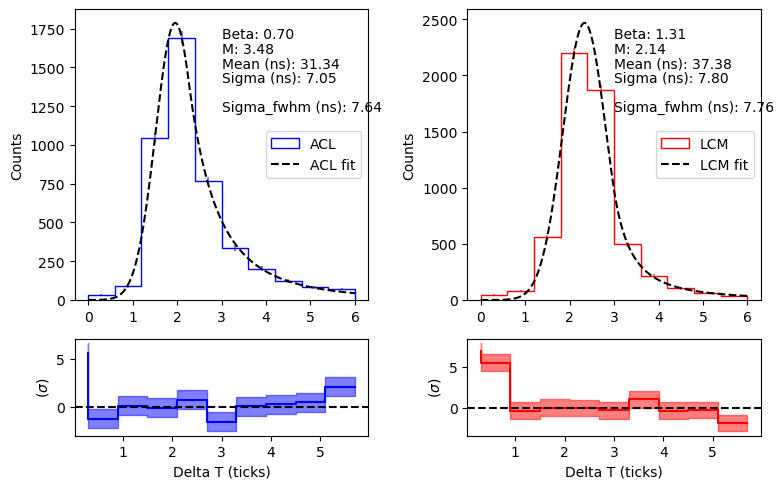

In [56]:
from scipy.stats import crystalball

def crystal_ball(x, beta, m, loc, scale, amplitude):
    return amplitude * crystalball.pdf(-x, beta, m, loc=loc, scale=scale)

def plot_histogram_and_fit(ax_main, ax_resid, delta_t, color, label, nbins=10):
    # Histogram
    ax_main.hist(delta_t, bins=nbins, range=(0, tolerance), histtype='step', color=color, label=label)

    # Bin calculations
    hist, bin_edges = np.histogram(delta_t, bins=nbins, range=(0, tolerance))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    sqrtN = np.sqrt(hist)
    ax_main.errorbar(bin_centers, hist, yerr=sqrtN, fmt='none', color=color, alpha=0.5)

    # Fit Crystal Ball
    param_bounds = ([0.1, 0.1, -np.inf, 1e-6, 1e-6], [10, 10, np.inf, np.inf, np.inf])
    p0 = [1.5, 2.0, np.mean(delta_t), np.std(delta_t), max(hist)]
    popt, _ = curve_fit(crystal_ball, bin_centers, hist, p0=p0, bounds=param_bounds, maxfev=10000)

    # Plot fit
    ax_main.plot(interp_bin_centres, crystal_ball(interp_bin_centres, *popt), color='k', linestyle='--', label=f'{label} fit')

    # Labels
    ax_main.set_ylabel('Counts')
    ax_main.legend()

    # Residuals
    resids = (hist - crystal_ball(bin_centers, *popt))
    ax_resid.step(bin_centers, resids/sqrtN, color=color)
    ax_resid.fill_between(bin_centers, (resids-sqrtN)/sqrtN, (resids+sqrtN)/sqrtN, color=color, alpha=0.5, step='pre')
    ax_resid.axhline(0, color='k', linestyle='--')
    ax_resid.set_xlabel('Delta T (ticks)')
    ax_resid.set_ylabel(r'($\sigma$)')

    # Print fit parameters on the plot
    ax_main.text(0.5, 0.9, f'Beta: {popt[0]:.2f}', transform=ax_main.transAxes)
    ax_main.text(0.5, 0.85, f'M: {popt[1]:.2f}', transform=ax_main.transAxes)
    ax_main.text(0.5, 0.80, f'Mean (ns): {-popt[2]*16:.2f}', transform=ax_main.transAxes)
    ax_main.text(0.5, 0.75, f'Sigma (ns): {popt[3]*16:.2f}', transform=ax_main.transAxes)
    # sigma from fwhm
    max_val = np.max(crystal_ball(interp_bin_centres, *popt))
    fwhm = interp_bin_centres[np.where(crystal_ball(interp_bin_centres, *popt) > max_val/2)]
    fwhm = fwhm[-1] - fwhm[0]
    ax_main.text(0.5, 0.65, f'Sigma_fwhm (ns): {0.425*fwhm*16:.2f}', transform=ax_main.transAxes)


# Set up figure with GridSpec
fig, ax = plt.subplots(2, 2, figsize=(8, 5), gridspec_kw={'height_ratios': [3, 1]})
interp_bin_centres = np.linspace(0, tolerance, 1000)

# Plot ACL
plot_histogram_and_fit(ax[0, 0], ax[1, 0], acl_delta_t, 'b', 'ACL')

# Plot LCM
plot_histogram_and_fit(ax[0, 1], ax[1, 1], lcm_delta_t, 'r', 'LCM')

# Adjust layout
plt.tight_layout()
plt.show()


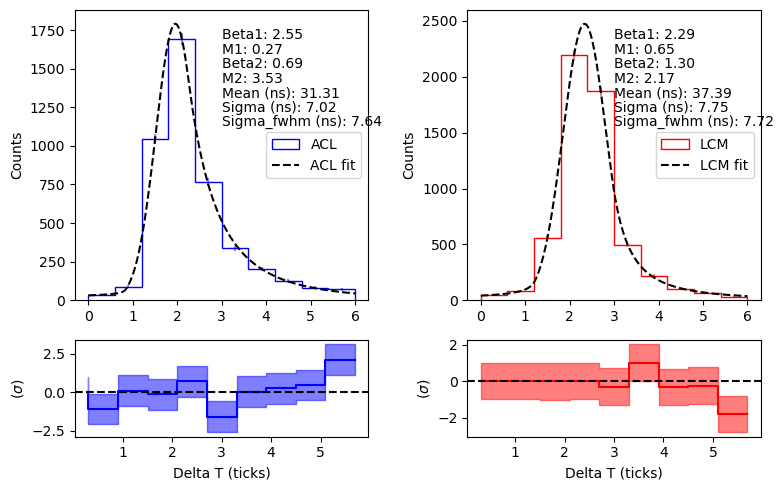

In [57]:
def double_sided_crystal_ball(x, beta1, m1, beta2, m2, loc, scale, amplitude):
    """
    A smooth Double-Sided Crystal Ball function.

    Parameters:
    - x: Data points.
    - beta1, m1: Left tail parameters (beta1 = tail exponent, m1 = curvature).
    - beta2, m2: Right tail parameters.
    - loc: Center of the distribution (mean).
    - scale: Core width (sigma).
    - amplitude: Scaling factor.

    Returns:
    - Smooth DSCB function values.
    """

    # Normalized distance from mean
    t = (x - loc) / scale

    # Transition points
    left_cutoff = -beta1
    right_cutoff = beta2

    y = np.zeros_like(t)

    # Left tail (x < loc - beta1 * scale)
    left_mask = t < left_cutoff
    if np.any(left_mask):
        A1 = (m1 / beta1) ** m1 * np.exp(-0.5 * beta1 ** 2)
        B1 = m1 / beta1 - beta1
        y[left_mask] = A1 * (B1 - t[left_mask]) ** -m1

    # Core Gaussian (-beta1 < t < beta2)
    core_mask = (t >= left_cutoff) & (t <= right_cutoff)
    if np.any(core_mask):
        y[core_mask] = np.exp(-0.5 * t[core_mask] ** 2)

    # Right tail (x > loc + beta2 * scale)
    right_mask = t > right_cutoff
    if np.any(right_mask):
        A2 = (m2 / beta2) ** m2 * np.exp(-0.5 * beta2 ** 2)
        B2 = m2 / beta2 - beta2
        y[right_mask] = A2 * (B2 + t[right_mask]) ** -m2

    return amplitude * y


def plot_histogram_and_fit(ax_main, ax_resid, delta_t, color, label, nbins=10):
    # Histogram
    ax_main.hist(delta_t, bins=nbins, range=(0, tolerance), histtype='step', color=color, label=label)

    # Bin calculations
    hist, bin_edges = np.histogram(delta_t, bins=nbins, range=(0, tolerance))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    sqrtN = np.sqrt(hist)
    ax_main.errorbar(bin_centers, hist, yerr=sqrtN, fmt='none', color=color, alpha=0.5)

    # Fit Double-sided Crystal Ball
    param_bounds = ([0.1, 0.1, 0.1, 0.1, -np.inf, 1e-6, 1e-6], [10, 10, 10, 10, np.inf, np.inf, np.inf])
    p0 = [1.5, 2.0, 1.5, 2.0, np.mean(delta_t), np.std(delta_t), max(hist)]
    popt, _ = curve_fit(double_sided_crystal_ball, bin_centers, hist, p0=p0, bounds=param_bounds, maxfev=10000)

    # Plot fit
    ax_main.plot(interp_bin_centres, double_sided_crystal_ball(interp_bin_centres, *popt), color='k', linestyle='--', label=f'{label} fit')

    # Labels
    ax_main.set_ylabel('Counts')
    ax_main.legend()

    # Residuals
    resids = (hist - double_sided_crystal_ball(bin_centers, *popt))
    ax_resid.step(bin_centers, resids/sqrtN, color=color)
    ax_resid.fill_between(bin_centers, (resids-sqrtN)/sqrtN, (resids+sqrtN)/sqrtN, color=color, alpha=0.5, step='pre')
    ax_resid.axhline(0, color='k', linestyle='--')
    ax_resid.set_xlabel('Delta T (ticks)')
    ax_resid.set_ylabel(r'($\sigma$)')

    # Print fit parameters on the plot
    ax_main.text(0.5, 0.9, f'Beta1: {popt[0]:.2f}', transform=ax_main.transAxes)
    ax_main.text(
        0.5, 0.85, f'M1: {popt[1]:.2f}', transform=ax_main.transAxes)
    ax_main.text(
        0.5, 0.80, f'Beta2: {popt[2]:.2f}', transform=ax_main.transAxes)
    ax_main.text(
        0.5, 0.75, f'M2: {popt[3]:.2f}', transform=ax_main.transAxes)
    ax_main.text(
        0.5, 0.70, f'Mean (ns): {popt[4]*16:.2f}', transform=ax_main.transAxes)
    ax_main.text(
        0.5, 0.65, f'Sigma (ns): {popt[5]*16:.2f}', transform=ax_main.transAxes)
    # sigma from fwhm
    max_val = np.max(double_sided_crystal_ball(interp_bin_centres, *popt))
    fwhm = interp_bin_centres[np.where(double_sided_crystal_ball(interp_bin_centres, *popt) > max_val/2)]
    fwhm = fwhm[-1] - fwhm[0]
    ax_main.text(0.5, 0.60, f'Sigma_fwhm (ns): {0.425*fwhm*16:.2f}', transform=ax_main.transAxes)

# Set up figure with GridSpec
fig, ax = plt.subplots(2, 2, figsize=(8, 5), gridspec_kw={'height_ratios': [3, 1]})
interp_bin_centres = np.linspace(0, tolerance, 1000)

# Plot ACL
plot_histogram_and_fit(ax[0, 0], ax[1, 0], acl_delta_t, 'b', 'ACL')

# Plot LCM
plot_histogram_and_fit(ax[0, 1], ax[1, 1], lcm_delta_t, 'r', 'LCM')

# Adjust layout
plt.tight_layout()
plt.show()